# Reinforcement Learning Case Study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1. Overview

- We will implement a simplified algorithmic trading strategy in Python using reinforcementlearning.
- Our agent will attempt to earn profit from market-making in a high-frequency market.
- We will consider a simplified environment, but the problem can be scaled up to more realistic scenarios.
- It is based on the work of [Chan and Shelton 2001; “An Electronic Market-Maker”](https://dspace.mit.edu/handle/1721.1/7220).
- A more structured, and fully commented, version of the code used in these notes is available on [github](https://github.com/phelps-sg/learning-market-maker/tree/master).

## 2. Training an agent in a simulation
- Allowing an agent to learn in the real-world can be risky.
- We can train our agent in a simulation environment.
- The simulation environment is sometimes called a “***gym***”.
- If the simulation is a good model of the real-world then the learned policy will still perform well in real-world.
- The agent can still adapt its policy online in the real-world even if the simulation is not a good model.

## 3. Define the Framework of Simulation - The Market Model
- We consider three types of agent:
    - informed traders,
    - uninformed traders, and
    - a single market-maker.
- Prices evolve intra-day in discrete time periods t ∈ N.
- A single asset is traded.
- All trades and orders involve a single share of the asset.
- There is no order crossing between traders.
- The arrival of traders at the market follow a Poisson process.

### 3.1 The Fundamental Price
- The true price of the asset $p_t^* \in \mathbb{Z}$ follows a Poisson process.
- The parameter $\lambda_p\in [0,1]$ is the probability of a discrete change in the price.

$$ p_t^*(t) = p_0 + \sum_{i=1}^t \eta_t $$

, where $\eta_t$ is choosen i.i.d. from $(-1,+1,0)$ with probabilitites $(\lambda_p ,\lambda_p, 1-2\lambda_p)$ respectively.

### 3.2 The Market Maker

- In the simplest form of the model, the market maker posts a single price $p_t^m$.
- The market maker can adjust its price:

$$ p^m_{t+1} = p_t + \Delta p_t $$

, where the price changes are discrete and finite, $\Delta p_t \in \{ -1, 0, +1 \}$.

- The reward at time $t$ is the change in the profit:
    - for a sell order: $r_t = p_t^* - p_t^m$
    - for a buy order: $r_t = p_t^m - p_t^*$
- More advanced versions of the model consider separate bid and ask prices, and corresponding spread.

### 3.3 Informmed Traders
- Informed traders have information about the fundamental price, $p_t^*$. *(The True Market Price)*
- They can submit market orders for immediate execution at the market-maker’s price, $p_t^m$. *( The Price you can buy and sell at the Exchange)*
- They submit
    - a buy order iff. $p_t^* > p_t^m $. 
    - a sell order iff. $p_t^* < p_t^m $. 
    - no order iff.$ p_t^* = p_t^m $.
- They arrive at the market with probability $\lambda_i$. *(Sometimes the Informed Traders arrive and find no distroted market price, and so they do not trade. Sometimes, they trade)*

### 3.4 Uninformed traders
- Uninformed traders arrive at the market with probability $2 \lambda_u$.
- They submit a buy order for $+1$ shares with probability $\lambda_u$, or a sell order for $−1$ shares with equal probability $\lambda_u$.

### 3.5 The Overall Process

- All Poisson processes are combined:
$$2\lambda_p + 2\lambda_u + \lambda_i = 1$$
- There is an event at every discrete time period $t$.
- Trade occurs a finite period of time $t \in \{ 1, 2, \cdots, T\}$ where $T$ is the duration of a single trading day.
- The market maker operates over many days.
- The initial conditions for every day are the same; they are independent *episodes*.

### 3.6 The Market Maker as an Agent

- We can consider the market-maker as an adaptive agent.
- The environment consists of the observable variables in the market.
- Initially the observable state is the total order-imbalance $IMB_t$ .
- The variables are discrete, therefore there is a discrete state space.
- The market-maker chooses actions in discrete time periods $t$.
- The set of actions A available to the agent is $\Delta p \in \mathbb{A} = {-1,0,+1}$.
- It can choose actions conditional on observations in order to maximise expected return $\mathbb{E}[G]$, where $G = \sum_t \gamma^t r_t .

#### Pearameterising the Model
In the following examples we use the parameterisation of the model:

- $\lambda_p = 0.2$ - the fundamental price up/down prob
- $\lambda_i = 0.4$ - the informed trader arriving market prob
- $\lambda_u = 0.1$ - the uninformed trader arriving at market prob
- $T = 150$ - finite number of periods
- $p_0^* = 200$

In [2]:
INITIAL_PRICE = 200 
MAX_T = 150

PROB_PRICE = 0.2

PROB_PRICE_UP = PROB_PRICE 
PROB_PRICE_DOWN = PROB_PRICE

PROB_UNINFORMED = 0.1

PROB_UNINFORMED_BUY = PROB_UNINFORMED 
PROB_UNINFORMED_SELL = PROB_UNINFORMED

PROB_INFORMED = 0.4

ALL_PROB = [PROB_PRICE_DOWN, 
            PROB_PRICE_UP, 
            PROB_UNINFORMED_BUY, 
            PROB_UNINFORMED_SELL, 
            PROB_INFORMED]

In [3]:
np.sum(ALL_PROB)

1.0

## 4. Representing Events

The event and probability distribution are:
- $Prob = [\lambda_p, \lambda_p, \lambda_u, \lambda_u, \lambda_i]=[0.2, 0.2, 0.1, 0.1, 0.4]$
- Event = [PriceUp, PriceDown, UninformedBuy, UninformedSell, InformedArrival] = [0, 1, 2, 3, 4]


- The uninfomred traders have no information, so they buy or sell randomly with equal prob = 0.1 in our assumption.
- The informed traders know the market, so once they arrive with prob 0.4, they can earn from the distroted market price for sure if the accumulated distrotion reaches the threshold.

In [4]:
EVENT_PRICE_CHANGE_UP    = 0
EVENT_PRICE_CHANGE_DOWN  = 1
EVENT_UNINFORMED_BUY     = 2
EVENT_UNINFORMED_SELL    = 3
EVENT_INFORMED_ARRIVAL   = 4

ALL_EVENT = [EVENT_PRICE_CHANGE_DOWN, 
             EVENT_PRICE_CHANGE_UP, 
             EVENT_UNINFORMED_SELL, 
             EVENT_UNINFORMED_BUY, 
             EVENT_INFORMED_ARRIVAL]

## 5. Simulating the Poisson Process

Produce **a Random Event Set** based on (1) the Event Set and (2) Probability Distribution.

The Possion Distribution is used to simulate a discrete event occurs several times within a certain time period.

In [5]:
def simulate_events(probabilities=ALL_PROB):
    # simulate one of the 5 events with the given probabilities ALL_PROB
    return np.random.choice(ALL_EVENT, p=probabilities, size=MAX_T)

In [6]:
events = simulate_events()

# i.e. the first 10 events
events[:10]

array([4, 4, 3, 4, 4, 1, 4, 3, 4, 1])

In [56]:
len(events)  # gives MAX_T

150

### 5.1 Simulating the Price Process

In [57]:
fundamental_price_changes = np.zeros(MAX_T)

In [58]:
fundamental_price_changes[events == EVENT_PRICE_CHANGE_DOWN] = -1
fundamental_price_changes[events == EVENT_PRICE_CHANGE_UP] = +1

In [59]:
fundamental_price_changes[:10]

array([ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.])

In [60]:
fundamental_price = INITIAL_PRICE + np.cumsum(fundamental_price_changes)

print('The first 10 events happened results in the stock price movement', fundamental_price[:10])

The first 10 events happened results in the stock price movement [200. 200. 200. 200. 200. 199. 199. 199. 199. 198.]


#### Wrap up previous lines as a Function

In [61]:
def simulate_fundamental_price(events):
    price_changes = np.zeros(MAX_T)
    price_changes[events == EVENT_PRICE_CHANGE_DOWN] = -1
    price_changes[events == EVENT_PRICE_CHANGE_UP] = +1
    return INITIAL_PRICE + np.cumsum(price_changes)

fundamental_price = simulate_fundamental_price(events)

#### A single realisation of the price process.

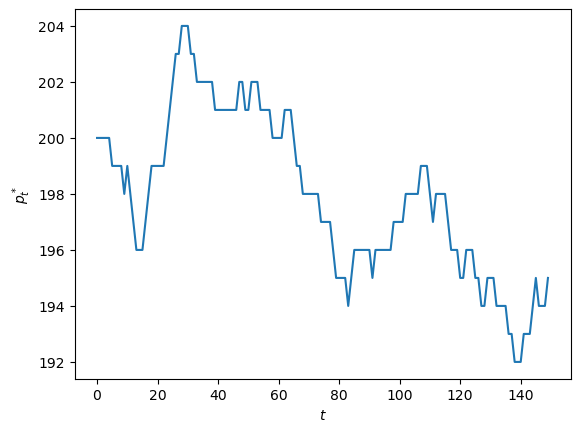

In [62]:
plt.plot(fundamental_price)
plt.xlabel('$t$')
plt.ylabel('$p_t^*$')
plt.show()

Discrete plot on both axes which is reasonable assumption for high-frequency trading (many many trades in small time windows, so price might be stable within that window).

### 5.2 Simulate the Uninformed Traders

In [65]:
def simulate_uninformed_orders(events):
    orders = np.zeros(MAX_T)
    orders[events == EVENT_UNINFORMED_BUY] = +1
    orders[events == EVENT_UNINFORMED_SELL] = -1
    return orders

uninformed_orders = simulate_uninformed_orders(events)
uninformed_orders[:10]

array([ 0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.])

#### Uninformed Order-imbalance

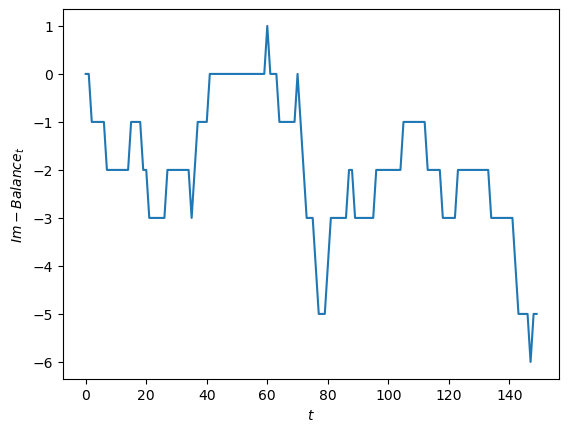

In [66]:
plt.plot(np.cumsum(uninformed_orders))
plt.xlabel('$t$'); plt.ylabel('$Im-Balance_t$')
plt.show()

### 5.3 Informed Traders

#### 5.3.1 A Simple Market-Making Strategy
Initially, we consider a very simple policy for our market-making agent.


- The policy $\pi_h$ is parameterised by a single threshold parameter $h$.
    - Increase the price by a single tick if the order-imbalance is $+h$.
    - Decrease the price by a single tick if the order-imbalance is $−h$.
    
#### 5.3.2 The Reward Function

In [67]:
def informed_strategy(current_price, mm_price):
    if current_price > mm_price:
        return 1
    elif current_price < mm_price:
        return -1
    else:
        return 0

# if the accummulated distroted price = the threshold, 
# then flag to buy or sell or hold (maps from a state to an action)
def mm_threshold_strategy(order_imbalance, threshold=2):
    if order_imbalance == -threshold:  # order imbalance is too negative
        return -1  # asset is overpriced, bring it down
    elif order_imbalance == +threshold:
        return +1  # asset is underpriced
    else:
        return 0

# execute the distroted orders
def mm_reward(current_fundamental_price, mm_current_price, order_sign):
    if order_sign < 0:
        return current_fundamental_price - mm_current_price
    elif order_sign > 0:
        return mm_current_price - current_fundamental_price
    else:
        return 0

## 6. The Market Simulation

- The uninfomred traders have no information, so they buy or sell randomly with equal prob = 0.1 in our assumption.
- The informed traders know the market, so once they arrive with prob 0.4, they can earn from the distroted market price for sure if the accumulated distrotion reaches the threshold.

Recall

`EVENT_PRICE_CHANGE_UP    = 0
EVENT_PRICE_CHANGE_DOWN  = 1
EVENT_UNINFORMED_BUY     = 2
EVENT_UNINFORMED_SELL    = 3
EVENT_INFORMED_ARRIVAL   = 4`

In [69]:
def simulate_market(events, uninformed_orders, fundamental_price, 
                    mm_strategy=mm_threshold_strategy, threshold=2): 
    """
    Output: mm_prices, 
            order_imbalances, 
            rewards, 
            actions
    """
    # threshold = 2 means the informed trade would execute the distrotion once the accumulated distrotion is +2 or -2

    mm_prices = np.zeros(MAX_T)
    order_imbalances = np.zeros(MAX_T) 
    informed_orders = np.zeros(MAX_T)
    rewards = np.zeros(MAX_T)
    actions = np.zeros(MAX_T) 
    t_mm = 0; 
    mm_current_price = INITIAL_PRICE

    for t in range(MAX_T):
        # if the informed trader arrival, that is if event == 4
        if events[t] == EVENT_INFORMED_ARRIVAL: 
            # informed traders' strategy is to arbitrage
            order = informed_strategy(fundamental_price[t], mm_current_price)
            informed_orders[t] = order
        # if the informed trader does not arrive, then uninformed trader execute
        else:
            # uninformed trader's strategy is to buy or sell randomly with equal prob = 0.2
            order = uninformed_orders[t]

        # sum of orders from informed & uninformed,
        # once the acuumulated imbalance reach the threshold = 2,
        # then the informed traders execute the imbalance and reset the time  t_mm
        imbalance = np.sum(informed_orders[t_mm:t] + uninformed_orders[t_mm:t])
        mm_price_delta = mm_strategy(imbalance, threshold)  # initial hard-coded policy
        if mm_price_delta != 0:  # then set a new starting point
            t_mm = t 
            mm_current_price += mm_price_delta

        # record what happened in for this time t
        order_imbalances[t] = imbalance
        mm_prices[t] = mm_current_price
        actions[t] = mm_price_delta
        rewards[t] = mm_reward(fundamental_price[t], mm_current_price, order)

    return mm_prices, order_imbalances, rewards, actions

### 6.1 Order-Imbalance Time Series

Recall we set the threshold = 2, so the imbalance has min/max of -2 & 2, and then the informed trader would execute the distrotion.

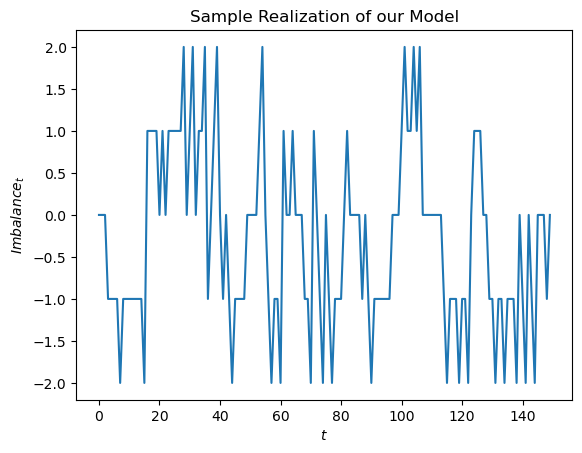

CPU times: total: 62.5 ms
Wall time: 472 ms


In [73]:
%%time

mm_prices, order_imbalances, rewards, actions = \
    simulate_market(events, uninformed_orders, fundamental_price, threshold=2)

plt.plot(order_imbalances)
plt.xlabel('$t$')
plt.ylabel('$Imbalance_t$')
plt.title("Sample Realization of our Model")
plt.show()

### 6.2 Price Time Series

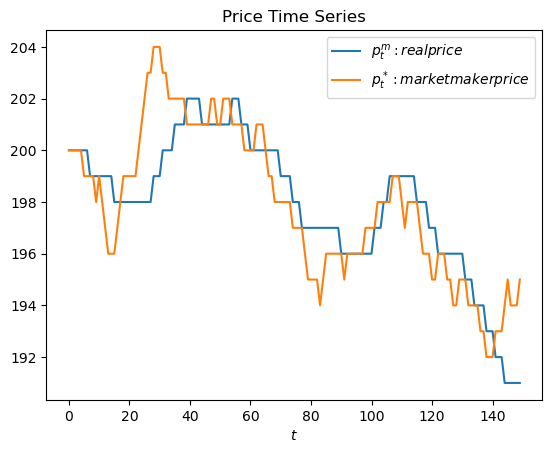

In [75]:
plt.plot(mm_prices)
plt.plot(fundamental_price)
plt.xlabel('$t$')
plt.legend(['$p^m_t: real price$','$p^*_t: marketmaker price$'])
plt.title("Price Time Series")
plt.show()

### 6.3 Reward Time Series $r_t$

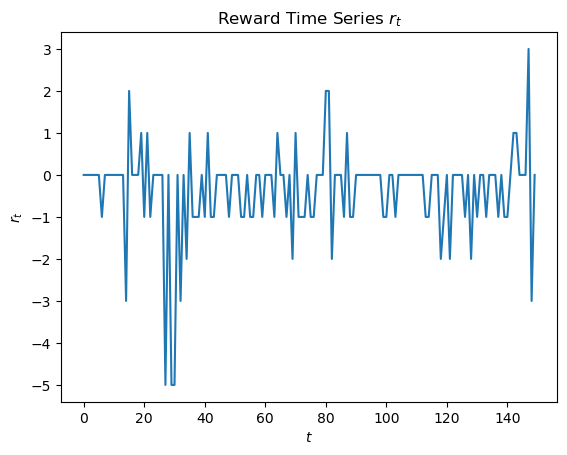

In [76]:
plt.plot(rewards)
plt.xlabel('$t$')
plt.ylabel('$r_t$')
plt.title("Reward Time Series $r_t$")
plt.show()

## 7. Policy evaluation
- Each value of the threshold parameter h defines a policy $\pi_h$ .
- In the experiments above we set $h = 2$.
- We can estimate the expected reward, and hence the expected return, across the episode.
- With no time-discounting, i.e. $\gamma = 1$, the return $G$ is approximately:

In [77]:
np.mean(rewards) * MAX_T

-54.99999999999999

- We could use this as an estimate of the expected return to the policy E( G ).
- However, we have only used a single sample.

## 8. Monte-carlo policy evaluation

See the following post for better illustration.

https://towardsdatascience.com/q-learning-and-sasar-with-python-3775f86bd178

- We will attempt to obtain more accurate value estimates using Monte-Carlo estimation.
- First we restructure our code so that we can easily rerun an entire simulation with given parameters.

In [78]:
# restructure the code for make the MC simu a bit easier
def simulate_all(mm_strategy=mm_threshold_strategy, threshold=1, probabilities=ALL_PROB):
    events = simulate_events(probabilities)
    fundamental_price = simulate_fundamental_price(events)
    uninformed_orders = simulate_uninformed_orders(events)
    return simulate_market(events, uninformed_orders, fundamental_price, mm_strategy, threshold)

In [79]:
%%time

mm_prices, order_imbalances, rewards, actions = simulate_all(threshold=1) 
np.mean(rewards)

CPU times: total: 0 ns
Wall time: 6.74 ms


-0.4866666666666667

We are going to lose money on average! So this is not a good policy. Maybe need to adjust the policy / threshold.

### 8.1 Using the sample-mean to estimate expected value
- We realise the model many times.
- Each realisation is a single episode or trajectory.
- We can consider each episode as a sample.
- We use the sample mean as the best estimator for the expectation.

In [81]:
def evaluate(policy, probabilities=ALL_PROB, samples=1000):
    """
    Parameter Policy is the threhold
    Call the simulation function 1000x and take mean of the rewards (index [2]) to obtain return
    """
    # the second element in the output list is the 'reward'
    return np.mean([np.mean(simulate_all(threshold=policy)[2]) for i in range(samples)]) 

### 8.2 Comparing policies

From below results, we can find that the expected reward decreases with the increase in policy (threshold) level.

The result makes sense that high threshold/policy means higher level of accumulated imbalanaces are needed for the informed traders to execute.

$v(\pi_1)\approx$

In [82]:
%%time
evaluate(policy=1)

CPU times: total: 422 ms
Wall time: 2.85 s


-0.43799333333333335

$v(\pi_2)\approx$

In [83]:
%%time
evaluate(policy=2)

CPU times: total: 406 ms
Wall time: 2.39 s


-0.5345666666666667

$v(\pi_3)\approx$

In [84]:
%%time
evaluate(policy=3)

CPU times: total: 438 ms
Wall time: 2.62 s


-0.6730933333333332

### 8.3 The value of states
- We can also estimate the value of a given state s assumming a fixed policy $\pi$.
- For a threshold $h = 2$, i.e. $\pi=\pi_2$ the states are $s\in \{ -2,-1,0,+1,+2 \}$.
- We first simulate a single episode.

In [88]:
mm_prices, order_imbalances, rewards, actions = simulate_all(threshold=2)

np.mean(rewards)

-0.42

### 8.4 The value of states

In [89]:
value_fn = {(state, np.mean(rewards[order_imbalances == state])) \
            for state in [-2, -1, 0, +1, +2]} 
value_fn

{(-2, 0.0),
 (-1, -0.3),
 (0, -0.41379310344827586),
 (1, -0.625),
 (2, -0.38461538461538464)}

It’s more elegant to represent this as a Python dictionary:

In [90]:
value_dict = dict(value_fn)

To compute $v_{\pi_2}(1)$ we can use the following

In [91]:
value_dict[1]

-0.625

### 8.5 The value of states
Note that in the previous section our estimate was based on a single episode.

Below we extend the code on the previous section to average over many episodes (samples).

In [92]:
def expected_reward_by_state(mm_strategy, threshold, probabilities=ALL_PROB, samples=1000):

    states = range(-threshold, threshold+1) 
    result = np.zeros((samples, len(states)))

    for i in range(samples):
        rewards = simulate_all(mm_strategy, threshold)[2]
        result[i, :] = [np.mean(rewards[order_imbalances == state]) for state in states]

    return dict(zip(states, np.nanmean(result, axis=0)))

##### Policy Comparison

$v_{\pi_1}(s)\approx$

In [93]:
expected_reward_by_state(mm_threshold_strategy, threshold=1)

{-1: -0.4287000000000004, 0: -0.4250862068965514, 1: -0.4472499999999998}

Best state to be in is the middle one at 0 (least negative reward).

$v_{\pi_2}(s)\approx$

In [95]:
expected_reward_by_state(mm_threshold_strategy, threshold=2)

{-2: -0.5417777777777762,
 -1: -0.5107000000000004,
 0: -0.527482758620689,
 1: -0.5635500000000011,
 2: -0.5634615384615385}

## 9. The value of state action pairs

Ideally we would like to compute $v_{\pi}(s,a)$.

In [96]:
def q_table(result, all_actions, all_states):
    return pd.DataFrame(result, 
                        columns=[f"$\Delta p={i}$" for i in all_actions], 
                        index=all_states)

def expected_reward_by_state_action(mm_strategy, threshold, probabilities=ALL_PROB, samples=1000):

    all_states = range(-threshold, threshold+1) 
    all_actions = [-1, 0, +1] 
    result = np.zeros((samples, len(all_states), len(all_actions)))

    for i in range(samples):
        _, states, rewards, actions = simulate_all(mm_strategy, threshold)
        result[i, :, :] = np.reshape([np.nanmean(rewards[(states == state) & (actions == action)]) \
                                        for state in all_states for action in all_actions], (len(all_states), len(all_actions)))
    return np.nanmean(result, axis=0)

### 9.1 The value function obtained from $\pi_2$

In [97]:
%%time
Q = expected_reward_by_state_action(mm_threshold_strategy, threshold=2, samples=10000) 
q_table(Q, [-1, 0, +1], range(-2, 3))

CPU times: total: 8.16 s
Wall time: 43.7 s


,$\Delta p=-1$,$\Delta p=0$,$\Delta p=1$
-2,-0.38445,NaN,NaN
-1,NaN,-0.560478,NaN
0,NaN,-0.562155,NaN
1,NaN,-0.569419,NaN
2,NaN,NaN,-0.394788


## 10. Exploration of the state-space

In [99]:
def mm_exploration_strategy(order_imbalance, threshold=2, epsilon=0.025):
    if np.random.random() <= epsilon:  # add exploration with probability epsilon
        return np.random.choice([-1, 0, +1]) 
    else:  # exploit
        if order_imbalance == +threshold:
            return -1 
        elif order_imbalance == -threshold:
            return +1 
        else:
            return 0

### 10.1 Results from Monte-Carlo policy evaluation

In [101]:
%%time
Q = expected_reward_by_state_action(mm_exploration_strategy, threshold=2, samples=50000)  # more samples now....

CPU times: total: 42.9 s
Wall time: 3min 17s


Now the table is fully populated values for every state!

In [102]:
q_table(Q, [-1, 0, +1], range(-2, 3))

,$\Delta p=-1$,$\Delta p=0$,$\Delta p=1$
-2,-5.930124,-5.999236,-5.927619
-1,-5.581456,-6.097291,-6.185744
0,-5.600273,-5.790019,-5.695590
1,-6.288129,-6.080731,-6.135893
2,-5.865778,-6.440820,-6.044634


The greedy policy:

In [103]:
dict({(s, np.where(Q[s+2, :] == np.max(Q[s+2, :]))[0][0] - 1) for s in range(-2, 3)})

{2: -1, -1: -1, -2: 1, 1: 0, 0: -1}

## 11. Policy Improvement - Explore + Exploit
- We have estimated $Q_{\pi}(s,a)=\hat{v}_{\pi}(s,a) \quad \forall s\in \mathbb{S}, \forall a \in \mathbb{A}$ for a given policy $\pi$.
- **If our estimates are accurate, we can use the function $Q$ to find a better policy**.
- To improve the policy we can simply take the **greedy action** for a given state: $\pi'(s) = arg\max_a Q_{\pi}(s,a)$.
- For the corresponding proof, see the policy improvement theorem.

## 12. Policy iteration
- Note, however, that if we change the policy from $\pi$ to $\pi'$, that our value estimates are outdated.
- Value estimates $Q_{\pi}(s,a)$ are obtained from following a given policy $\pi$.
- Value estimates and policies are not independent of each other.
- Therefore we should re-estimate $Q'_{\pi'}(s,a)$ for the new policy as $\hat{v}_{\pi'}(s,a)$.
- We iterate until the policy and value estimates converge:

$$ \pi(s,a) \to Q_{\pi}(s,a)\to \pi'(s,a)\to Q'_{\pi'}(s,a) \to \pi''(s,a) \to \cdots$$

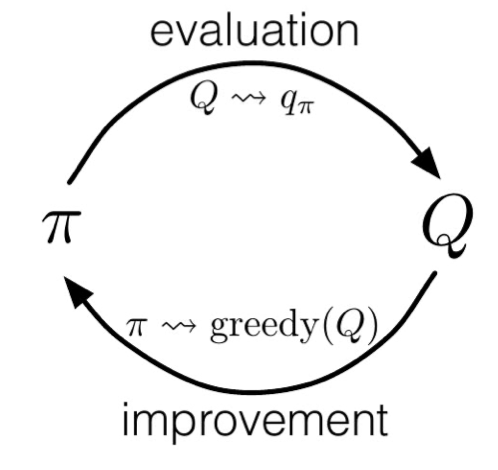

### 12.1 Generalised Policy Iteration
- Many reinforcement-learning interleaving policy improvement and value estimation;
    - improve policy based on incomplete samples, while
    - improving value estimates by following a (sub-optimal) policy.
- These techniques are called Generalised Policy Iteration (GPI) methods.

## 13. Temporal-difference (TD) Learning

Recall that:

$$\begin{equation}\begin{split}
v_{\pi}(s) &= \mathbb{E}_{\pi}[G_t|s_t=s]\\
&= \mathbb{E}_{\pi}[r_{t+1} + \gamma G_{t+1}|s_t=s]\\
&= \mathbb{E}_{\pi}[r_{t+1} + \gamma v_{\pi}(s_{t+1})|s_t=s]
\end{split}\end{equation}$$

- When we use Monte-Carlo methods, $G_t$ is unknown, so we estimate $G_t$ from sampled returns.
- When we use dynamic-programming $v_{\pi}(s_{t+1})$ is unknown, so we use our existing estimate $\hat{v}_{\pi}(s_{t+1}) = V(s_{t+1})$ instead.
- Temporal difference learning combines both estimates with recency $\alpha$:

$$ V(s) \leftarrow V(s) + \alpha [r_t + \gamma V(s_{t+1}) - V(s_t)] $$

- We can generalise this to $Q$:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [r_t + \gamma Q(s_{t+1},a_{t+1})-Q(s_t, a_t)]$$

## Initialising the Q table

We first define our action space $\Delta p_t \in \mathbb{A}$ and state space $IMB_t \in \mathbb{S}$.

In [40]:
all_actions = [-1, 0, +1] 
all_states = range(-2, +3)

We will use a matrix to represent our current estimates $Q$.

In [41]:
def initialise_learner():
    return np.zeros((len(all_states), len(all_actions)))

In [42]:
Q = initialise_learner() 
q_table(Q, all_actions, all_states)

,$\Delta p=-1$,$\Delta p=0$,$\Delta p=1$
-2,0.0,0.0,0.0
-1,0.0,0.0,0.0
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0


### Functions to manipulate $Q$

We define the following functions to map from the state and action space into indices of the matrix.

In [43]:
def state(imbalance, all_states=range(-2, +3)):
    s = int(imbalance) - all_states[0]
    ms = len(all_states)-1 
    if s > ms:
        return ms 
    elif s < 0:
        return 0 
    else:
        return s

def action(price_delta):
    return int(price_delta) + 1

We then define functions to obtain $Q$ values from specified actions and states.

In [44]:
def q_values(Q, imbalance):
    return Q[state(imbalance), :]

def q_value(Q, imbalance, price_delta):
    return Q[state(imbalance), action(price_delta)]

## Temporal-Difference Learning in Python

**State–action–reward–state–action (SARSA)** is an algorithm for learning a Markov decision process policy, used in the reinforcement learning area of machine learning. 

We can translate the following equation

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t, a_t)]$$

into Python:

In [45]:
def update_learner(s, a, r, s_, a_, Q, alpha=0.01, gamma=0.0):
    Q[state(s), action(a)] += alpha * (r + gamma * q_value(Q, s_, a_) - q_value(Q, s, a))

Now we must modify our simulation code to provide feedback to the agent.

## The Market-Maker as a Reinforcement-Learning Agent

In [46]:
def simulate_learning_mm(Q, events, uninformed_orders, fundamental_price,mm_policy):
    # initialising
    mm_prices = np.zeros(MAX_T, dtype=int); 
    order_imbalances = np.zeros(MAX_T, dtype=int) 
    informed_orders = np.zeros(MAX_T, dtype=int); 
    rewards = np.zeros(MAX_T); 
    actions = np.zeros(MAX_T, dtype=int); 
    mm_t_last_change = 0 
    mm_current_price = INITIAL_PRICE 
    # looping
    for t in range(MAX_T):
        if events[t] == EVENT_INFORMED_ARRIVAL: # if informed trader arrives
            order = informed_strategy(fundamental_price[t], mm_current_price)
            informed_orders[t] = order
        else:
            order = uninformed_orders[t] # if informed trader not arrives, then uninformed traders execute
        imbalance = np.sum(informed_orders[mm_t_last_change:t] +uninformed_orders[mm_t_last_change:t]) 
        mm_price_delta = mm_policy(imbalance) # if the imbalance accumulates to a threshold, then mm_price_delta gets a value
        if mm_price_delta != 0:
            mm_t_last_change = t # update a new time split to accumulate the imbalance
            mm_current_price += mm_price_delta # update mm_current_price
        order_imbalances[t] = imbalance # save the imbalance to a list
        mm_prices[t] = mm_current_price # update mm_price
        
        actions[t] = mm_price_delta;
        rewards[t] = mm_reward(fundamental_price[t], mm_current_price, order)
        
        # conduct the learning process
        if t>0:
            update_learner(order_imbalances[t-1], actions[t-1], rewards[t-1], imbalance, mm_price_delta, Q) 
        
    return fundamental_price, mm_prices, order_imbalances, rewards, actions, Q

## On-Policy Control

- Now we can combine policy improvement and policy estimation in a single step.
- This algorithm is called SARSA, which is named after the arguments to the function `update_learner`.
- We use TD learning to bootstrap $Q$ values, and then form an $\epsilon$-greedy policy using our value estimates.

In [47]:
def mm_learning_strategy(Q, s, epsilon=0.1):
    if np.random.random() <= epsilon:
        action = np.random.choice([-1, 0, +1]) 
    else:
        values = q_values(Q, s) 
        max_value = np.max(values) 
        action = np.random.choice(np.where(values == max_value)[0]) - 1 
    return action

In [48]:
# epsilon-greedy action
def simulate_learning(Q, probabilities=ALL_PROB):
    events = simulate_events(probabilities) 
    fundamental_price = simulate_fundamental_price(events) 
    uninformed_orders = simulate_uninformed_orders(events)

    def sarsa(s):
        return mm_learning_strategy(Q, s)

    return simulate_learning_mm(Q, events, uninformed_orders, fundamental_price, mm_policy=sarsa)

## Learning over a Single Episode

In [49]:
Q = initialise_learner()

fundamental_price, mm_prices, order_imbalances, rewards, actions, Q = simulate_learning(Q)

q_table(Q, all_actions, all_states)

,$\Delta p=-1$,$\Delta p=0$,$\Delta p=1$
-2,0.000000,0.000000,-0.050000
-1,0.319639,-0.267817,-0.285116
0,-0.513010,-0.713956,-0.565850
1,-0.375238,-0.662402,-0.548302
2,0.051883,-0.179100,-0.218311


## Learning over Many Episodes

- We simply iterate over many trading days (i.e. episodes) in order to gradually learn the optimal policy.
- Each episode is independent, but notice that we re-use the Q-values from the previous episode.
- This ensures that we learn across episodes.

In [50]:
%%time

EPISODES = 5000
for i in range(EPISODES):
    fundamental_price, mm_prices, order_imbalances, rewards, actions, Q = simulate_learning(Q)

CPU times: total: 5.14 s
Wall time: 27.5 s


## The results

The learned $Q$ values:

In [51]:
q_table(Q, all_actions, all_states)

,$\Delta p=-1$,$\Delta p=0$,$\Delta p=1$
-2,-2.499425,-2.283395,-2.129741
-1,-0.279271,-1.046570,-1.449329
0,-1.063621,-0.576284,-0.895065
1,-1.066337,-0.974056,-0.492899
2,-2.098567,-1.720642,-1.098336


The greedy policy:

In [52]:
{(s, np.where(Q[state(s), :] == np.max(Q[state(s), :]))[0][0] - 1) for s in all_states}

{(-2, 1), (-1, -1), (0, 0), (1, 1), (2, 1)}

## The Prices from the Final Trading Day

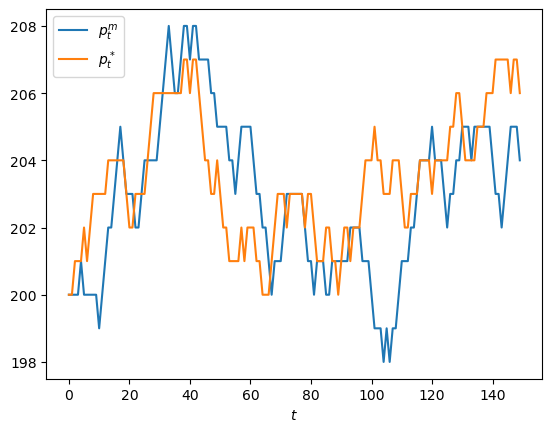

In [53]:
plt.plot(mm_prices); 
plt.plot(fundamental_price) 
plt.xlabel('$t$'); 
plt.legend(['$p^m_t$','$p^*_t$']) 
plt.show()

## The Rewards in the Final Day

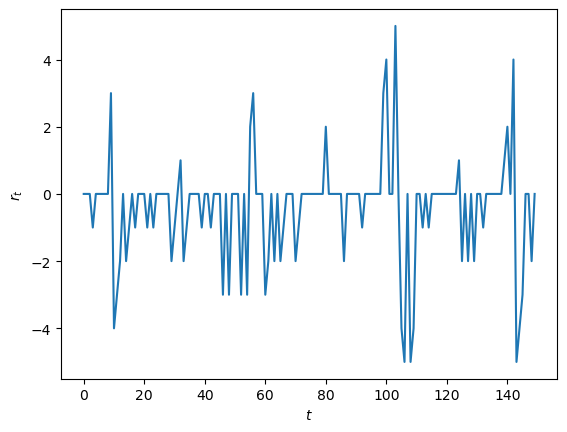

In [54]:
plt.plot(rewards) 
plt.xlabel('$t$'); 
plt.ylabel('$r_t$') 
plt.show()

## Conclusion
- We have implemented a very simple market-making strategy in a simplified model of a financial market.
- The framework is very flexible, and can be extended to more realistic applications, e.g. separate bid and ask qutes.
- We can use a simulation model to initially train our agent.
- However, the agent can learn directly from the environment in the absence of a model.
- Reinforcement-learning can be very useful in reducing model-risk.

# Bibliography

Chan, N. T., & Shelton, C. (2001). An electronic market-maker.

Ganchev, K., Nevmyvaka, Y., Kearns, M., & Vaughan, J. W. (2010). Censored exploration and the dark pool problem. Communications of the ACM, 53(5), 99-107.

Mani, M., Phelps, S., & Parsons, S. (2019). Applications of Reinforcement Learning in Automated Market-Making.

Sutton, R. S., & Barto, A. G. (2011). Reinforcement learning: An introduction.

# Further reading on agent-based modeling

Farmer, J. D., & Foley, D. (2009). The economy needs agent-based modelling. Nature, 460(7256), 685-686.

Lo, A. W. (2004). The adaptive markets hypothesis. The Journal of Portfolio Management, 30(5), 15-29.

Phelps, S. (2012). Applying dependency injection to agent-based modeling: the JABM toolkit. WP056-12, Centre for Computational Finance and Economic Agents (CCFEA), Tech. Rep.

Tesfatsion, L., & Judd, K. L. (Eds.). (2006). Handbook of computational economics: agent-based computational economics. Elsevier.